# Machine Learning Algorithms from Scratch

## Contents

1. K-means
2. Gradient Descent & Linear Regression
3. Logistic Regression (Binary Classification, <span style="color:red">Multiclass Classification</span>)
4. Principal Components Analysis
5. K Nearest Neighbours <span style="color:red">(visualize results)</span>
6. <span style="color:red">Decision Trees</span>

<span style="color:red">To dos in red</span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pylab inline

from IPython.display import display

print (sys.version)

Populating the interactive namespace from numpy and matplotlib
3.7.1 (default, Dec 14 2018, 13:28:58) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


## 1. K-means

### Algorithm:

1. Randomly define k cluster centres
2. Assign each data point to the nearest cluster centre
3. Re-calculate the cluster centres as the Euclidean mean of the members of each cluster
4. Calculate the max distance the cluster centres moved
5. Re-peat steps 2 - 4 until the labels stop changing 

In [2]:
class Kmeans:
    def __init__(self, data, k = 2):
        self.data = data
        self.n_data, self.n_features = data.shape
        self.mean = np.mean(data, axis=0)
        self.var = np.var(data, axis=0)
        self.stdev = np.sqrt(self.var)
        self.tol = 0.01
        self.k = k

    def get_initial_centres(self, seed = -1):
        if seed > 0:
            np.random.seed(seed)
        centres = np.random.normal(size = (self.k, self.n_features))
        return centres*self.stdev + self.mean
    
    def distances_from_centres(self, centres, p):
        return np.sqrt(np.sum((p-centres)*(p-centres), axis=1))

    def nearest_cluster(self, centres):
        cluster_labels = np.zeros((self.n_data,1))
        for di in range(self.n_data):
            cluster_labels[di,0] = np.argmin(self.distances_from_centres(centres, self.data[di,:]))
        return cluster_labels

    def calculate_cluster_centres(self, cluster_labels):
        centres = np.zeros((self.k, self.n_features))
        for c in range(self.k):
            n_pts = np.sum(cluster_labels == c)
            # Don't move the point if no data points are assigned to the cluster
            # This also prevents division by zero
            if n_pts > 1:
                centres[c,:] = np.sum((cluster_labels == c)*self.data, axis=0) / n_pts
        return centres
    
    def find_cluster_centres(self, initial_centres, max_iterations = 20):
        
        centres = np.copy(initial_centres)
        self.k = centres.shape[0]
        labels = np.zeros((self.n_data,1))
        
        for i in range(max_iterations):
            
            # Assign each data point to the closest cluster centre
            new_labels = self.nearest_cluster(centres)

            # Calculate the new cluster centres (mean of all points in each cluster)
            new_centres = self.calculate_cluster_centres(new_labels)

            # Calculate the max change in the distance between cluster centres
            #max_centre_change = np.max(self.distances_from_centres(centres, new_centres))
            n_labels_changed = np.sum((new_labels-labels) != 0)
            #print("centre: ", max_centre_change, "label:", n_label_changed)
            
            if n_labels_changed == 0:
                print("converged in {} iterations".format(i))
                break
            
            centres = np.copy(new_centres)
            labels = np.copy(new_labels)
            
        return centres, new_labels

Intial centres
[[ 3.72302948 -1.288815  ]
 [-1.17544466 -2.28531331]
 [ 1.99591807 -4.93977036]
 [ 3.99717436 -1.61171876]]
converged in 9 iterations
Final centres
[[ 2.1858432   2.03485541]
 [-2.1286218   1.98239571]
 [-1.8922867  -1.84433513]
 [ 2.05373119 -1.88840285]]


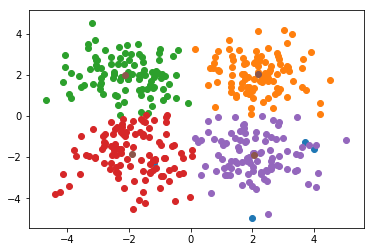

In [3]:
"""Set-up some data"""
np.random.seed(1)
x = 2
data1 = np.random.normal(size=(100, 2)) + [ x, x]
data2 = np.random.normal(size=(100, 2)) + [ x,-x]
data3 = np.random.normal(size=(100, 2)) + [-x,-x]
data4 = np.random.normal(size=(100, 2)) + [-x, x]
data  = np.concatenate((data1, data2, data3, data4))
np.random.shuffle(data)


"""Set up our Kmeans object"""
my_kmeans = Kmeans(data, 4)
initial_centres = my_kmeans.get_initial_centres(1)

print('Intial centres')
print(initial_centres)

"""Plot the initial centres"""
ax = plt.scatter(initial_centres[:,0], initial_centres[:,1])

"""Find the cluster centres using Kmeans"""
centres, labels = my_kmeans.find_cluster_centres(initial_centres)
print("Final centres")
print(centres)

"""Plot the data clusters given by Kmeans"""
dataa = data[np.where(labels[:,0] == 0)]
datab = data[np.where(labels[:,0] == 1)]
datac = data[np.where(labels[:,0] == 2)]
datad = data[np.where(labels[:,0] == 3)]

ax = plt.scatter(dataa[:,0], dataa[:,1])
ax = plt.scatter(datab[:,0], datab[:,1])
ax = plt.scatter(datac[:,0], datac[:,1])
ax = plt.scatter(datad[:,0], datad[:,1])
ax = plt.scatter(centres[:,0], centres[:,1])

## 2. Gradient Descent & Linear Regression

In [4]:
class LinearFunction:
    """Form: y = Ax"""
    def __init__(self, x, y):
        self.n_feat = x.shape[0]
        self.n_data = x.shape[1]
        self.x = np.concatenate((np.ones((1, self.n_data)), x), axis=0)
        #params will be an n_feat + 1 dimensional vector
        self.y = y
    
    def value(self, params):
        return params.dot(self.x)

    def deriv(self, params):
        return self.x


class MeanSumSqDiffs:
    def __init__(self, y, func):
        self.y = y
        self.func = func
        self.yhat = np.zeros_like(y)
    
    def value(self, params):
        self.y_hat = self.func.value(params)
        return np.mean((self.y_hat - self.y)*(self.y_hat - self.y))
    
    def delta(self, params):
        dy_hat = self.func.deriv(params)
        return 2 * np.transpose(np.mean((self.y_hat - self.y) * dy_hat, axis=1, keepdims=True))


class GradientDescent:
    def __init__(self, cost_function, learning_rate = 0.1, tol = 0.01, max_iter = 10):
        self.cost = cost_function
        self.alpha = learning_rate
        self.tol = tol
        self.max_iter = max_iter
        
    def find_minima(self, initial_params):
        params = np.copy(initial_params)
        val = self.cost.value(params)
        cost = [val]
        for i in range(self.max_iter):
            new_params = params - self.alpha * self.cost.delta(params)
            new_val = self.cost.value(new_params)
            cost.append(new_val)
            if np.abs(new_val - val) < self.tol:
                print('converged in {} iterations'.format(i))
                break
            params = np.copy(new_params)
            val = np.copy(new_val)
        return new_params, cost

converged in 65 iterations


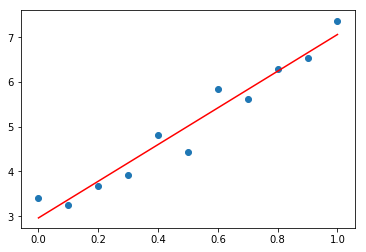

In [5]:
"""Set up some data"""
m = 11
step = 1.0 / (m - 1)
x = np.reshape(np.arange(0, 1 + step, step), (1, m))
np.random.seed(1)
noise = 0.25 * np.random.randn(1, m)
params = np.reshape(np.array([3, 4]), (1, 2))
y = np.reshape(params[0][0] + params[0][1] * x + noise, (1, m))

"""Plot the data"""
ax = plt.scatter(x, y)

"""Set up classes and find the best params using GradientDescent"""
linear_func = LinearFunction(x, y)
cost_func = MeanSumSqDiffs(y, linear_func)
grad_desc = GradientDescent(cost_func, learning_rate = 0.5, tol = 0.000001, max_iter = 100)
params, cost = grad_desc.find_minima(np.reshape(np.array([1, 1]), (1, 2)))

"""Plot our line of best fit"""
yhat = linear_func.value(params)
ax = plt.plot(np.transpose(x), np.transpose(yhat), 'red')

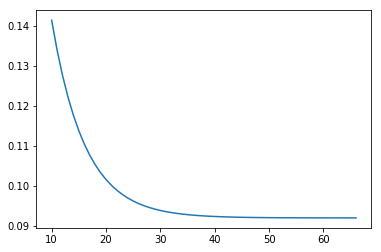

In [6]:
"""Plot the cost"""
start_index = 10
plt.gcf().clear()
plt.close()
ax = plt.plot(list(range(start_index, len(cost), 1)), cost[start_index:])

## 3. Logistic Regression

### 3.1 Binary Classification

In [7]:
class LogisticRegression:
    def __init__(self, x, y):
        self.n_feat = x.shape[0]
        self.n_data = x.shape[1]
        self.x = np.concatenate((np.ones((1, self.n_data)), x), axis=0)
        #params will be an n_feat + 1 dimensional vector
        self.y = np.reshape(y, (1, self.n_data))
        self.prob = np.zeros_like(y)
    
    def z(self, params):
        """Linear Function of Form: z = Ax"""
        return params.dot(self.x)
    
    def value(self, params):
        """sigmoid(z), z = Ax"""
        self.prob = 1.0 / (1.0 + np.exp(-self.z(params)))
        return self.prob


class CrossEntropy:
    def __init__(self, y, func):
        self.n_data = y.shape[0]
        self.y = np.reshape(y, (1, self.n_data))
        self.y_hat = np.zeros_like(y)
        self.func = func
    
    def value(self, params):
        self.y_hat = self.func.value(params)
        return - np.mean( y*np.log(self.y_hat) + (1.0 - y)*np.log(1.0 - self.y_hat) )
    
    def delta(self, params):
        return (self.y_hat - self.y).dot(np.transpose(self.func.x))/self.n_data

converged in 78 iterations
[[-0.73458739  3.04377256  2.72099494]]


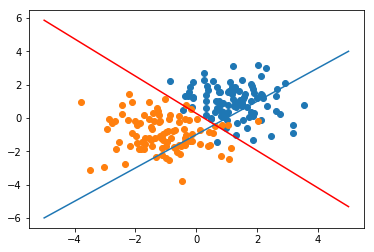

In [8]:
"""Set-up some data"""

np.random.seed(1)
x = 1
m = 200
data1 = np.concatenate((np.random.normal(size=(int(m/2), 2)) + [ x, x], np.ones((int(m/2), 1))), axis=1)
data2 = np.concatenate((np.random.normal(size=(int(m/2), 2)) + [-x, -x], np.zeros((int(m/2), 1))), axis=1)
data  = np.concatenate((data1, data2))
np.random.shuffle(data)
data_df = pd.DataFrame(data=data, columns=['x1', 'x2', 'y'])
#display(data_df)

y = data[:,2]
#print(data[:,:2].shape)

"""Plot the different classes"""
ax = plt.scatter(data1[:,0], data1[:,1])
ax = plt.scatter(data2[:,0], data2[:,1])


"""Setup our objects"""
model_prob = LogisticRegression(np.transpose(data[:,:2]), y)
cost_func = CrossEntropy(y, model_prob)
grad_desc = GradientDescent(cost_func, learning_rate = 3, tol = 0.00001, max_iter = 10000)

"""Pick an initial guess for a decision boundary and plot it"""
params = [1.0, -1.0, 1.0]
dbx = np.arange(-5, 6, 1)
dby = -(params[0] + params[1]*dbx)/params[2]
ax = plt.plot(dbx, dby)

"""Find the best params using GradienDescent and plot the new decision boundary"""
params, cost = grad_desc.find_minima(np.reshape(np.array(params), (1, 3)))
print(params)
dby = -(params[0][0] + params[0][1]*dbx)/params[0][2]
ax = plt.plot(dbx, dby, 'red')

"""Print the final params"""
y_hat = model_prob.value

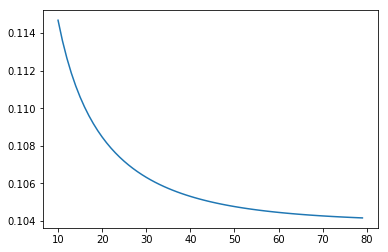

In [9]:
"""Plot the cost"""
start_index = 10
plt.gcf().clear()
plt.close()
ax = plt.plot(list(range(start_index, len(cost), 1)), cost[start_index:])

### 3.2 Multiclass Classification

In [10]:
"""
class LogisticRegression:
    def __init__(self, x, y, n_clases):
        self.n_feat = x.shape[0]
        self.n_data = x.shape[1]
        self.n_classes = n_clases
        self.x = np.concatenate((np.ones((self.n_data, 1)), x), axis=1)
        #params will be an n_feat + 1 dimensional vector
        self.y = y
            
    
    def z(self, params):
        #Linear Function of Form: z = Ax
        return params.dot(self.x)
    
    def value(self, params):
        #softmax(z), z = Ax
        ez = np.exp(self.z(params))
        ez_sum = np.sum(ez, axis=1)
        return ez / ez_sum

    def deriv(self, params):
        return pass


class CrossEntropy:
    def __init__(self, y, n_classes, func):
        self.n_data = y.shape[1]
        self.n_classes = n_classes
        self.y = y
        self.y_hat = np.zeros_like(y)
        self.func = func
    
    def value(self, params):
        y_hat = self.func.value(params)
        # yhat is an n_classes X n_data
        for i in range(self.n_data):
            self.y_hat[i] = y_hat[self.y[i], i]
        return -np.sum( np.log(self.yhat) )
    
    def delta(self, params):
        dy_hat = self.func.deriv(params)
        #print('testing', np.mean((self.y_hat - self.y) * dy_hat, axis=0, keepdims=True).shape)
        return pass
"""
print('To be continued at a later date')

To be continued at a later date


## 4. Principal Components Analysis

In [11]:
class PCA:
    def __init__(self, X):
        self.n_data = X.shape[0]
        self.n_feat = X.shape[1]
        self.X = np.transpose(X)
        self.mu = np.mean(self.X, axis=1, keepdims=1)
        self.var = np.var(self.X, axis=1, keepdims=1, ddof=1)
        self.eigenvalues, self.eigenvectors = self.sort_eigens()
        self.transformed_X = self.X.T.dot(self.eigenvectors)
        
    def calculation_checks(self):
        print('\ncorrelation matrix check (rho = {}):'.format(rho))
        print(np.cov(self.X - self.mu)/np.sqrt(self.var[0]*self.var[1]))
        
        print('\nmean:')
        print(self.mu.T)
        print('transformed mean:')
        print(self.mu.T.dot(self.eigenvectors))
        print('transformed data mean:')
        print(np.mean(self.transformed_X, axis=0))
        
        print('\nvariance:')
        print(self.var.T, np.sum(self.var))
        print('transformed data variance:')
        print(np.var(self.transformed_X, axis=0, ddof=1), np.sum(np.var(self.transformed_X, axis=0, ddof=1)))
        print('eigenvalues:')
        print(self.eigenvalues, np.sum(self.eigenvalues))
        print('eigenvectors:')
        print(self.eigenvectors)
        
        print('\nexplained variance:')
        print(self.explained_variance())
    
    def sort_eigens(self):
        vals, vecs = np.linalg.eig(np.cov(self.X - self.mu))
        index_order = vals.argsort()[::-1]
        return vals[index_order], vecs[:,index_order]
    
    def explained_variance(self):
        total_var = sum(self.eigenvalues)
        return [val / total_var for val in self.eigenvalues]

rho =  0.8 sqrt(1-rho*rho) =  0.5999999999999999

correlation matrix check (rho = 0.8):
[[1.06411064 0.7729556 ]
 [0.7729556  0.93975191]]

mean:
[[2.07531502 2.07591412]]
transformed mean:
[[2.93298138 0.11820359]]
transformed data mean:
[2.93298138 0.11820359]

variance:
[[0.95602214 0.84429531]] 1.8003174522884442
transformed data variance:
[1.59684361 0.20347384] 1.8003174522884442
eigenvalues:
[1.59684361 0.20347384] 1.8003174522884446
eigenvectors:
[[ 0.73490973 -0.67816494]
 [ 0.67816494  0.73490973]]

explained variance:
[0.8869789079194753, 0.1130210920805246]


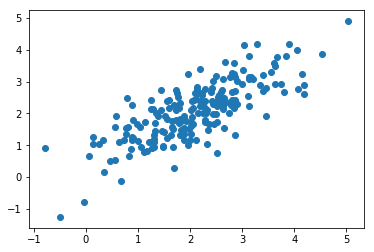

In [12]:
"""Set-up some data and plot it"""

np.random.seed(1)
m = 200
rho = 0.8
print('rho = ', rho, 'sqrt(1-rho*rho) = ', np.sqrt(1.0 - rho*rho))
data = np.random.normal(size=(m, 2))
data[:,1] = rho*data[:,0] + np.sqrt(1.0-rho*rho)*data[:,1]
data = data + 2.0
ax = plt.scatter(data[:,0], data[:,1])

"""Do PCA and do some checks on the results"""
my_PCA = PCA(data)
my_PCA.calculation_checks()

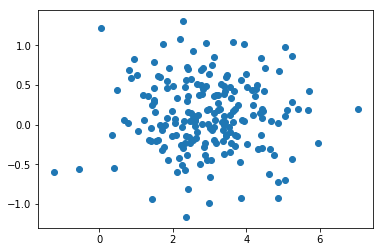

In [13]:
"""Plot the data in transformed space"""
new_data = my_PCA.transformed_X
plt.gcf().clear()
plt.close()
ax = plt.scatter(new_data[:,0], new_data[:,1])

## 5. K Nearest Neighbours

In [14]:
class KNN:
    def __init__(self, x, y):
        assert x.shape[0]== y.shape[0], 'KNN init: mismatched data sizes'
        self.x = x
        self.y = y
        self.n_data = x.shape[0]
        self.n_y = y.shape[1]
    
    def distances(self, p):
        return np.sqrt(np.sum((p-self.x)*(p-self.x), axis=1))
    
    def predict(self, xs, k):
        n_xs = xs.shape[0]
        predictions = np.ones((n_xs, self.n_y))
        for i in range(n_xs):
            k_indices = np.argsort(self.distances(xs[i,:]))[::-1][:k]
            knn = self.x[k_indices, :]
            if self.n_y == 1: predictions[i,:] = np.mean(knn)
            else:             predictions[i,:] = np.mean(knn, axis=1)
        return predictions

In [15]:
"""Setup some data"""
np.random.seed(1)
m = 2000
rho = np.array([0.6, 0.2])
data = np.random.normal(size=(m, 3))
data[:,2] = rho[0]*data[:,0] + rho[1]*data[:,1] + np.sqrt(1.0-np.sum(rho*rho))*data[:,2]

"""Pick some xs to make predictions for"""
xs = np.random.normal(size=(3, 2))

"""Setup the KNN object and predict the ys for our xs"""
my_knn = KNN(data[:,:2], data[:,2].reshape((m, 1)))
ys = my_knn.predict(xs, 5)

"""Print the xs and ys next to each other"""
print('xs, ys')
print(np.concatenate((xs, ys), axis=1))

xs, ys
[[-2.85106954  0.82312342  1.38623144]
 [-0.27474362 -0.68810141  1.92592107]
 [ 1.12008084  0.25209284 -0.87787057]]


## 6. Decision Trees